# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd
import math
import warnings

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import (Pipeline, 
                              make_pipeline)
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_error, 
                             confusion_matrix,
                             plot_confusion_matrix,
                             roc_curve,
                             auc,
                             precision_score, 
                             recall_score, 
                             f1_score)
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 666
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда градиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    w0 = np.cos(w[0])*np.sin(w[0])+np.sin(w[0])*np.cos(w[0])
    w1 = np.cos(w[1])*np.sin(w[1])+np.sin(w[1])*np.cos(w[1])
    
    return np.array([w0, w1])
    #return np.sin(2*w)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
print(grad_f(np.array([1, 2])))

[ 0.90929743 -0.7568025 ]


In [6]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [7]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :param x0: начальная точка
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)
    w0[0] = w0[0]*3-1.5
    w0[1] = w0[1]*3-1.5

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w)
        
    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [8]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.gca(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

C:\Users\U0139040\AppData\Local\Temp\ipykernel_1300\1727858522.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


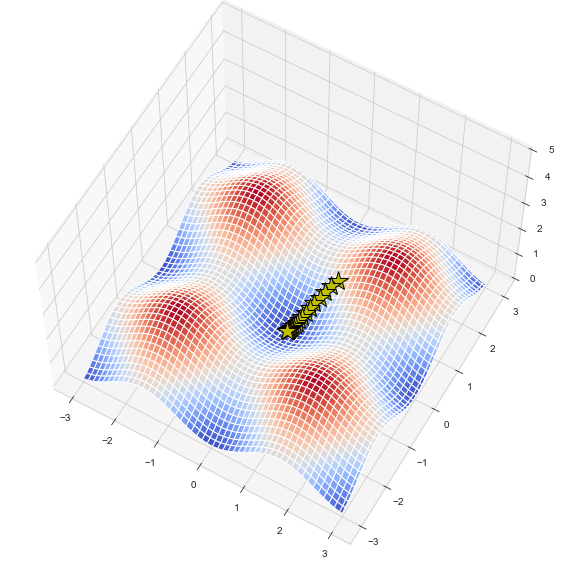

In [9]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

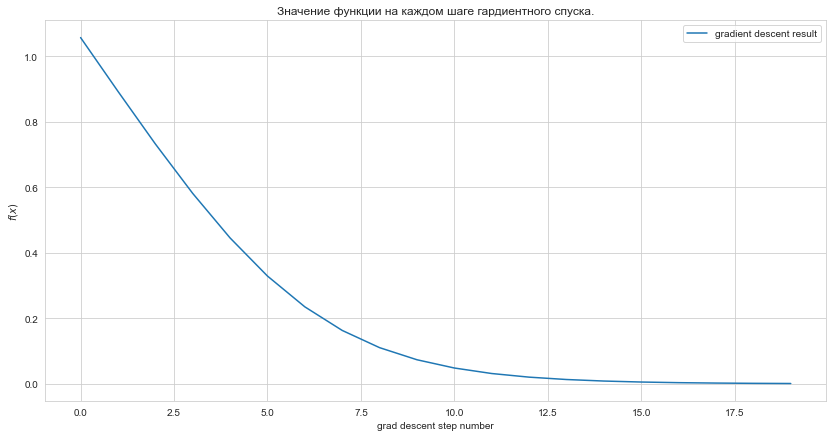

In [10]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [11]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    y_true = list(y_true)
    value = 0
    for m in range(0, len(y_true)):
        value += (y_true[m] - y_pred[m]) ** 2
    mse_calc = value / len(y_true)
    return mse_calc


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
 

    error_term = y_pred-y_true
    
    # np.matmul performs matrix multiplication
    # x.T is transpose of matrix x
    xt_dot_error_term = np.matmul(X.T, error_term)/len(X)
    return xt_dot_error_term


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [12]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достаточно просто разобраться с кодом.

In [13]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
        
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [14]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return np.matmul(X_test, self.W)
            
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [15]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

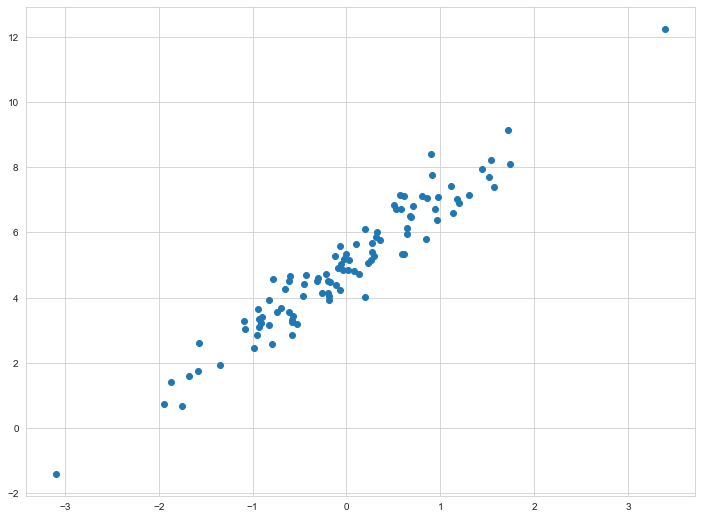

In [16]:
plt.scatter(X, y);

In [17]:
custom_lin_reg = CustomLinearRegression()

In [18]:
custom_lin_reg.fit(X, y)

My custom linear regression

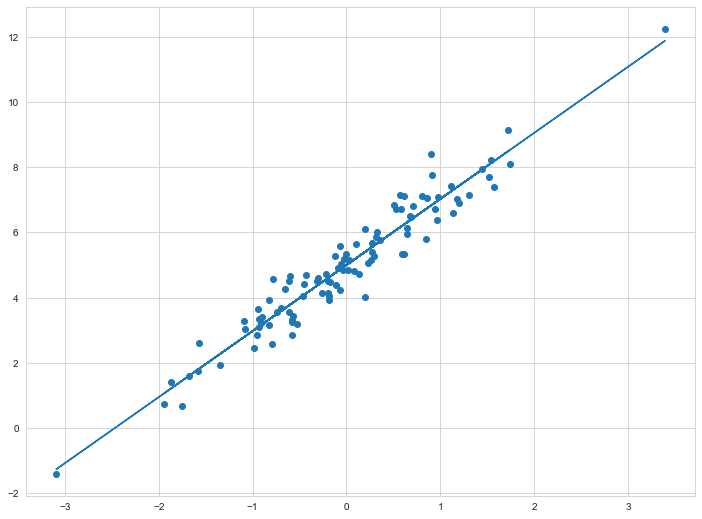

In [19]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Бостоне. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [20]:
warnings.filterwarnings('ignore')

In [21]:
data = load_boston()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

In [22]:
pd.DataFrame(X, columns = feature_names).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Ваш ход:

In [23]:
print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

# Create model with standartization:
regressorLR = LinearRegression()
scalerLR = StandardScaler()
pipelineLR = Pipeline(steps = [('scaling', scalerLR), ('regression', regressorLR)])

reg = pipelineLR
reg.fit(x_train, y_train)


# R2 score:
print(r2_score(y_test, reg.predict(x_test)))

# MSE:
print(mean_squared_error(y_test, reg.predict(x_test)))

# MAE:
print(mean_absolute_error(y_test, reg.predict(x_test)))



0.6171427719666898
29.64145746824258
3.391419742144675


In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

# Create model with standartization using Scaler:
regressorLR = LinearRegression()
scalerLR = StandardScaler()

scalerLR.fit(x_train)
regressorLR.fit(scalerLR.transform(x_train), y_train)


# R2 score:
print(r2_score(y_test, regressorLR.predict(scalerLR.transform(x_test))))

# MSE:
print(mean_squared_error(y_test, regressorLR.predict(scalerLR.transform(x_test))))

# MAE:
print(mean_absolute_error(y_test, regressorLR.predict(scalerLR.transform(x_test))))



0.7513840945903071
24.391955111064604
3.6487875921371304


In [26]:
pd.DataFrame(scalerLR.transform(x_test), columns=feature_names).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.279628,-0.46419,-0.498663,-0.260011,-0.195245,-0.222645,0.977736,0.014229,-0.681720,-0.654027,1.138945,-1.073442,1.019090
1,-0.457687,-0.46419,2.077007,-0.260011,0.168576,-0.420999,0.837227,-0.785868,-0.904550,-1.347770,0.247279,0.270608,0.687309
2,-0.434658,-0.46419,-0.138275,-0.260011,-0.609831,-1.227637,-2.081857,-0.068176,-0.681720,-0.828920,0.012630,-0.031384,2.287020
3,-0.447098,-0.46419,2.384440,-0.260011,0.405483,-1.224698,1.026915,-0.944414,-0.681720,1.701202,0.716577,-0.081923,1.518828
4,-0.456767,-0.46419,-0.223591,-0.260011,-0.119096,0.686843,0.440288,-0.503402,-0.458889,0.074695,-0.362808,0.451844,-0.382378


### **Not sure WHY we have difference in results of metrics of model quality using Pipeline and without Pipeline?**
Possibly the difference is brought by how Scaler works inside the Pipeline? 
What is the best way to standardize data according to your recommendations?

In [27]:
# Summarize the fit of the standardized model
print(feature_names)
print(regressorLR.intercept_, regressorLR.coef_)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
22.12427440633246 [-0.87004078  1.35571753 -0.06082026  0.80696599 -2.5605295   1.70286018
  0.51775627 -3.16046302  3.37062316 -2.34959821 -1.83919875  0.72914138
 -4.50670779]


**Looks like the most important parameters for the standardized model are: 'RAD' (index of accessibility to radial highways) and 'RM' (average number of rooms per dwelling), while 'ZN' (proportion of residential land zoned for lots over 25,000 sq.ft.) is not that important**

In [28]:
# Create model without standartization:
regressorLR = LinearRegression()

reg = regressorLR
reg.fit(x_train, y_train)


# R2 score:
print(r2_score(y_test, reg.predict(x_test)))

# MSE:
print(mean_squared_error(y_test, reg.predict(x_test)))

# MAE:
print(mean_absolute_error(y_test, reg.predict(x_test)))



0.8106126100165493
16.39598555091919
3.1967789121995636


In [29]:
# Summarize the fit of the non-standardized model
print(feature_names)
print(reg.intercept_, reg.coef_)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
42.41162056195316 [-1.01081818e-01  4.85192768e-02  2.34083297e-02  3.40635978e+00
 -1.81202692e+01  3.16934222e+00  6.36846509e-03 -1.48617253e+00
  3.17188101e-01 -1.17318448e-02 -1.07291579e+00  9.69666222e-03
 -5.57010120e-01]


**Looks like the most important parameters for NON-standardized model surprisingly are: 'B' (non-ethical parameter, proportion of blacks by town) and 'AGE' (proportion of owner-occupied units built prior to 1940), while 'ZN' (proportion of residential land zoned for lots over 25,000 sq.ft.) is not that important now.**

## Summary: As we can see, without standartization, the ethical problem become more significant.

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задачах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справиться с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [30]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1 / (1 + math.exp(-output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [31]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    res = 0
    for i in range(0, n):
        res -= (y_true[i] * math.log(sigmoid(y_pred[i])) + 
                (1 - y_true[i]) * math.log(1 - sigmoid(y_pred[i]))) / n
    return res
        
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]    
    
    res = [0] * n
    for i in range(0, n):
        res[i] = sigmoid(y_pred[i]) - y_true[i]
    out = np.matmul(X.transpose(), res)
    return out
        


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [32]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        
        probabilities = [0] * n_test_samples
        x_dot_weights = np.matmul(X_test, self.W)
        for i in range(0, n_test_samples):
            probabilities[i] = sigmoid(x_dot_weights[i])
        return np.round(probabilities)
           
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [33]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1, 
                           n_samples = 500)

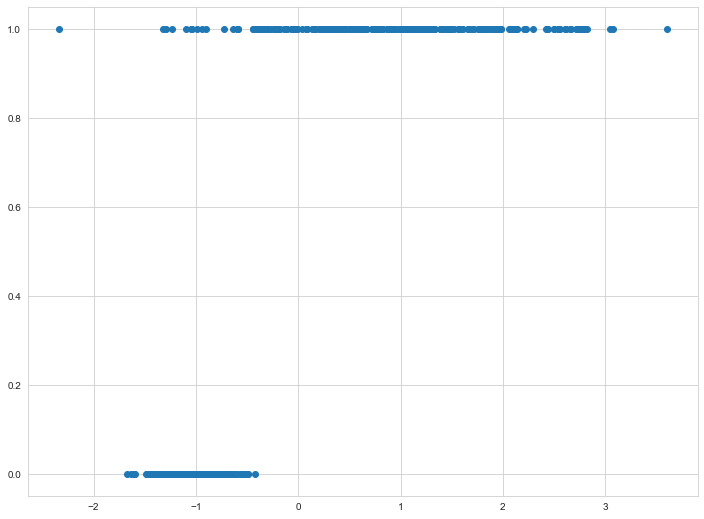

In [34]:
plt.scatter(X, y);

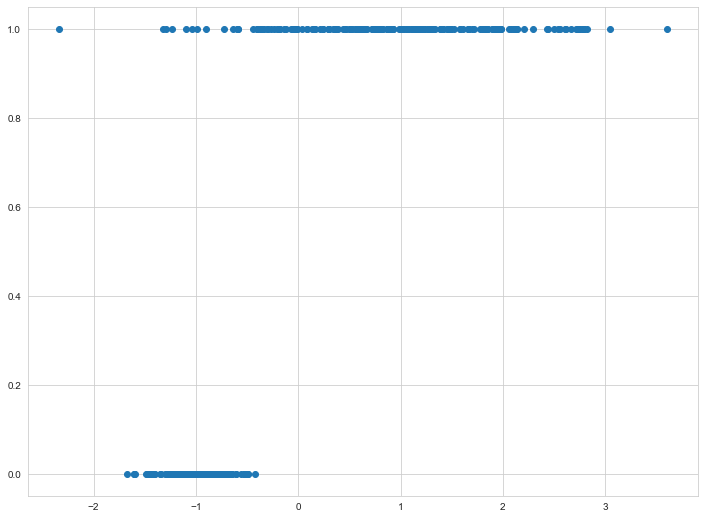

In [35]:
custom_log_reg = CustomLogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(X, y)
custom_log_reg.fit(x_train, y_train)
y_pred = custom_log_reg.predict(x_test)

plt.scatter(x_train, y_train);

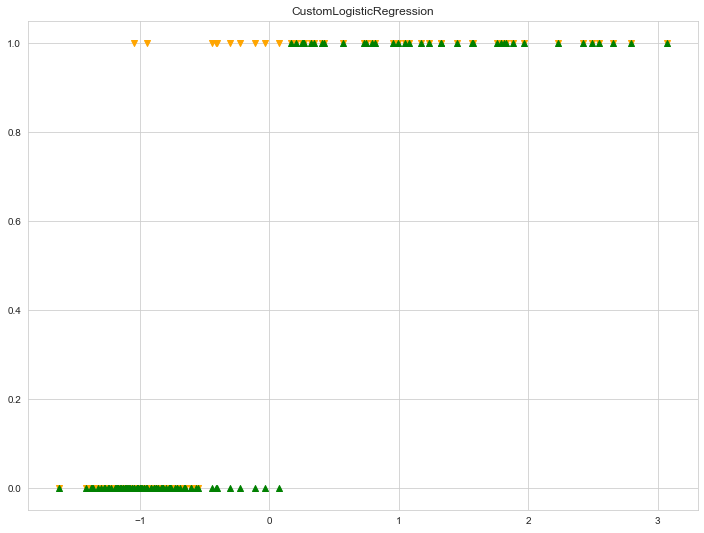

In [36]:
plt.scatter(x_test, y_test, marker = 'v', c = 'orange')
plt.scatter(x_test, y_pred, marker = '^', c = 'green')
plt.title('CustomLogisticRegression');

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [37]:
# Precision score:
print(precision_score(y_test, y_pred))

# Recall score:
print(recall_score(y_test, y_pred))

# F1 score:
print(f1_score(y_test, y_pred))

1.0
0.7916666666666666
0.8837209302325582


precision=1.000 recall=0.917 f1=0.957


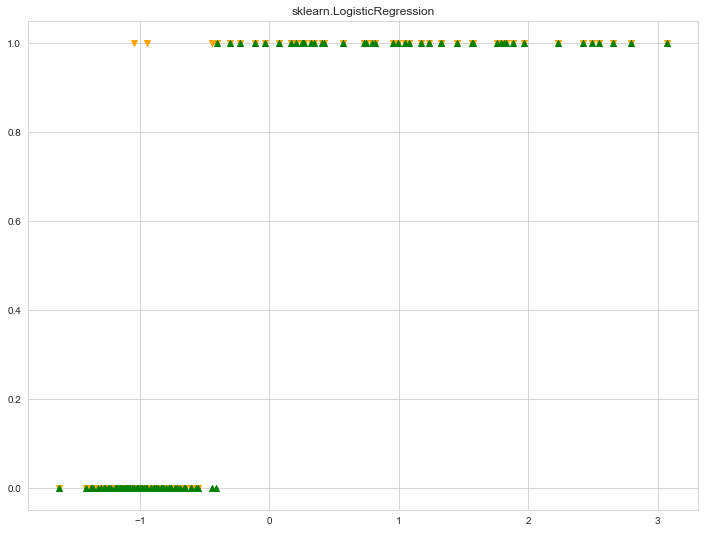

In [38]:
# Check our model with sklearn
clf = LogisticRegression(random_state=0).fit(x_train, y_train)

plt.scatter(x_test, y_test, color="orange", marker='v')
plt.scatter(x_test, clf.predict(x_test), color="green", marker='^')
plt.title('sklearn.LogisticRegression');

score_args = (y_test, clf.predict(x_test))
print(f"precision={precision_score(*score_args):.3f} recall={recall_score(*score_args):.3f} f1={f1_score(*score_args):.3f}")

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [39]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


### EDA

In [40]:
# Describe the dataset
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [41]:
# Drop columns with categorical parameters 
eda = pokemon.drop(columns = ['Name', 'Type 1', 'Type 2', 'Legendary'], inplace = False).copy()

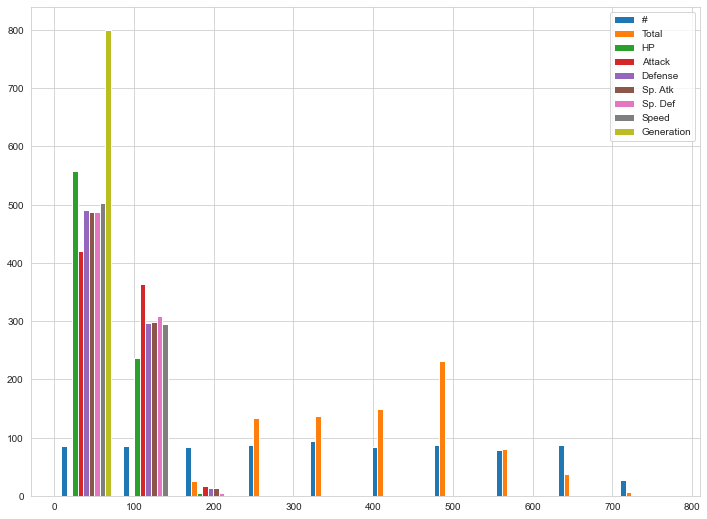

In [42]:
# Plot histogram distribution of the dataset
plt.hist(eda)
plt.legend(eda.columns.values, loc='upper right');
plt.show()

In [43]:
set(eda.Generation)

{1, 2, 3, 4, 5, 6}

**EDA showed that:**
1. Sum of characteristics ('Total') is very different amongst pokemons. Due to this we should make standartization of our data.
2. Column '#' is not distributed equally - thus, it is not an index.
3. Generation, surprisingly, is also a categorical parameter.
4. The rest of parameters are distributed more or less normally that shoulds be ok for further analysis.

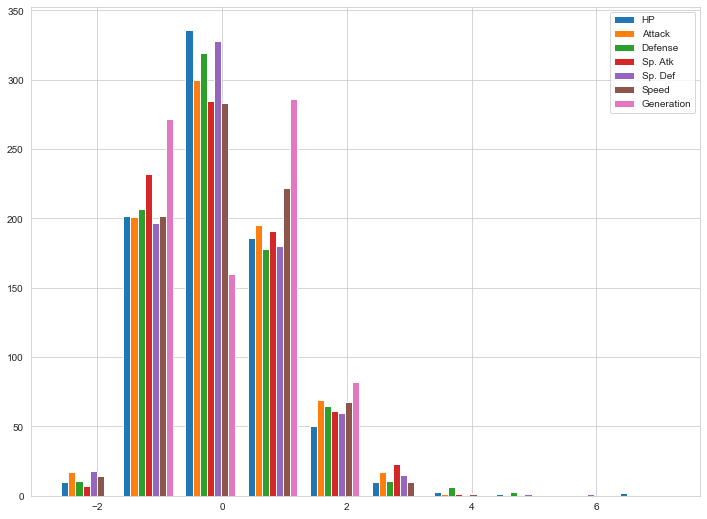

In [44]:
# Plot histogram distribution of the scaled dataset
eda = pokemon.drop(columns = ['Name', 'Type 1', 'Type 2', 'Legendary', 'Total', '#'], inplace = False).copy()
scalerLR = StandardScaler()

scalerLR.fit(eda)
plt.hist(scalerLR.transform(eda))
plt.legend(eda.columns.values, loc='upper right');
plt.show()

            #
Type 1       
Bug        69
Dark       31
Dragon     32
Electric   44
Fairy      17
Fighting   27
Fire       52
Flying      4
Ghost      32
Grass      70
Ground     32
Ice        24
Normal     98
Poison     28
Psychic    57
Rock       44
Steel      27
Water     112


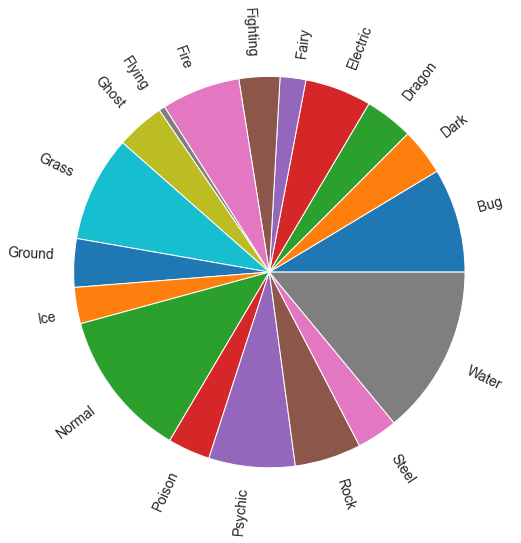

In [45]:
# Draw pie chart to visualize pokemon_dum type distribution (column 'Type')
eda = pokemon.drop(columns = ['Name', 'Type 2', 'Legendary', 'Total'], inplace = False).copy()
tb1 = pd.pivot_table(eda, values= '#', columns='Type 1', aggfunc=len)
tb1 = tb1.transpose()
tb1.head()
print(tb1)
plt.pie(tb1['#'], labels = tb1.index, rotatelabels = True, textprops = {'fontsize': 14})
plt.show()

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [46]:
pokemon['Legendary'] = pokemon['Legendary'].astype('int')
set(pokemon['Legendary'])

{0, 1}

**Type 2 is null for some pokemons, so let combine 'Type 1' and 'Type 2' into one parameter 'Type' and encode new parameter with 0 and 1:**

In [47]:
pokemon['Type 2'] = pokemon['Type 2'].fillna('')
pokemon['Type'] = pokemon['Type 1'] + pokemon['Type 2']

pokemon_dum = pd.get_dummies(data=pokemon, columns=["Type"])

pokemon_dum.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,...,Type_WaterFighting,Type_WaterFlying,Type_WaterGhost,Type_WaterGrass,Type_WaterGround,Type_WaterIce,Type_WaterPoison,Type_WaterPsychic,Type_WaterRock,Type_WaterSteel
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,0,0,0,0,0,0,0,0,0,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,0,0,0,0,0,0,0,0,0,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,0,0,0,0,0,0,0,0,0,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,...,0,0,0,0,0,0,0,0,0,0
4,4,Charmander,Fire,,309,39,52,43,60,50,...,0,0,0,0,0,0,0,0,0,0


               #
Type            
Bug           17
BugElectric    2
BugFighting    2
BugFire        2
BugFlying     14
...           ..
WaterIce       3
WaterPoison    3
WaterPsychic   5
WaterRock      4
WaterSteel     1

[154 rows x 1 columns]


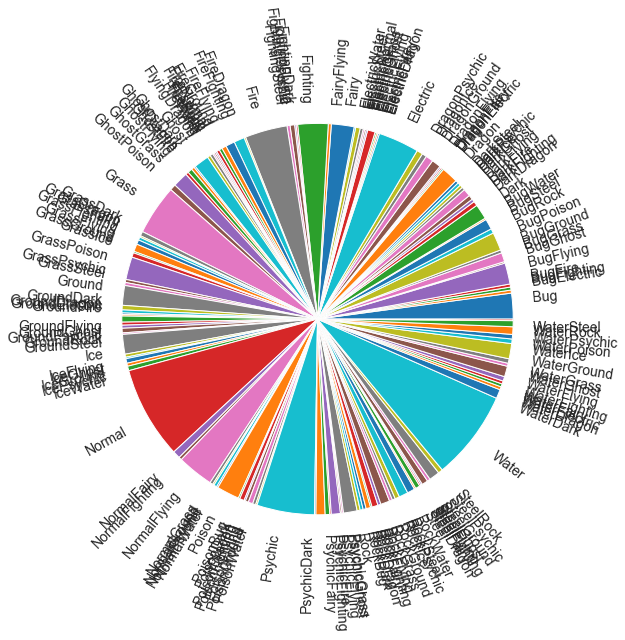

In [48]:
# Draw pie chart to visualize pokemon combined 'Type' distribution
eda = pokemon.drop(columns = ['Name', 'Type 2', 'Legendary', 'Total'], inplace = False).copy()
tb1 = pd.pivot_table(eda, values= '#', columns='Type', aggfunc=len)
tb1 = tb1.transpose()
tb1.head()
print(tb1)
plt.pie(tb1['#'], labels = tb1.index, rotatelabels = True, textprops = {'fontsize': 14})
plt.show()

**Let's drop all non-numerical parameters:**

In [49]:
pokemon_X = pokemon_dum.drop(columns = ['Name', 'Type 1', 'Type 2', 'Legendary', 
                                    'Generation', '#'], inplace = False).copy()
pokemon_X.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type_Bug,Type_BugElectric,Type_BugFighting,...,Type_WaterFighting,Type_WaterFlying,Type_WaterGhost,Type_WaterGrass,Type_WaterGround,Type_WaterIce,Type_WaterPoison,Type_WaterPsychic,Type_WaterRock,Type_WaterSteel
0,318,45,49,49,65,65,45,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,405,60,62,63,80,80,60,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,525,80,82,83,100,100,80,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,625,80,100,123,122,120,80,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,309,39,52,43,60,50,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Разделите ваши данные на тестовую и тренировочную выборку.

In [50]:
pokemon_y = pokemon['Legendary']

In [51]:
x_train, x_test, y_train, y_test = train_test_split(pokemon_X, pokemon_y)

Обучите модель `LogisticRegression` из `sklearn`.

In [52]:
regressorLR = LogisticRegression()
scalerLR = StandardScaler()

scalerLR.fit(x_train)
regressorLR.fit(scalerLR.transform(x_train), y_train)

LogisticRegression()

In [53]:
# Precision score:
print(precision_score(y_test, regressorLR.predict(scalerLR.transform(x_test))))

# Recall score:
print(recall_score(y_test, regressorLR.predict(scalerLR.transform(x_test))))

# F1 score:
print(f1_score(y_test, regressorLR.predict(scalerLR.transform(x_test))))

0.9
0.45
0.6


Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

In [54]:
conf_matx = confusion_matrix(y_test, regressorLR.predict(scalerLR.transform(x_test)))

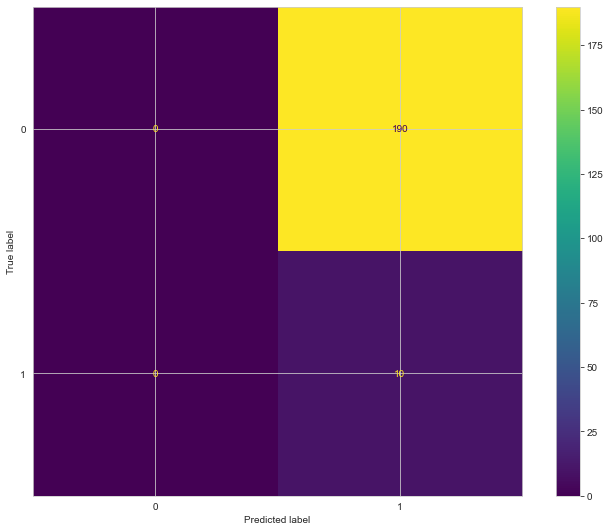

In [55]:
plot_confusion_matrix(regressorLR, x_test, regressorLR.predict(scalerLR.transform(x_test)))

In [56]:
classifier = OneVsRestClassifier(regressorLR)
y_score = classifier.fit(x_train, y_train).decision_function(x_test)

In [57]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

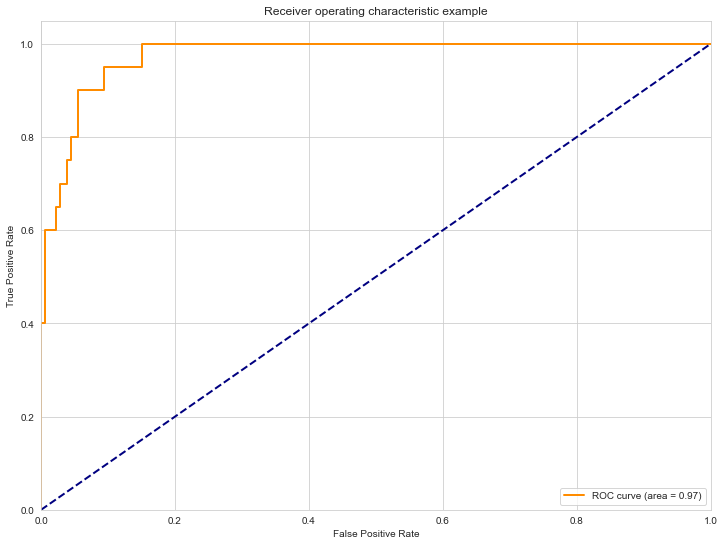

In [58]:
#Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

![alt text](https://media.sketchfab.com/models/0a0d3d35a5d24b52b8cac2c006215425/thumbnails/9f241fc3e2664a5d9ed8d17918bc3e41/7532821624224d0ca7745204e904dce3.jpeg)

### Calculate area under ROC

In [59]:
y_prob = classifier.decision_function(x_test)

In [60]:

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.974444 (macro),
0.974444 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.974444 (macro),
0.974444 (weighted by prevalence)


In [61]:
param_scores = pd.DataFrame([pokemon_X.columns.tolist(), regressorLR.coef_[0]], index = ['name', 'score']).transpose()

param_scores.sort_values(by = 'score', ascending = False).head(30)

,name,score
5,Sp. Def,1.066597
0,Total,1.006914
6,Speed,0.955635
1,HP,0.753855
4,Sp. Atk,0.635883
2,Attack,0.615026
116,Type_Psychic,0.518376
84,Type_Ground,0.409758
35,Type_DragonPsychic,0.407096
89,Type_GroundFlying,0.400621


In [62]:
param_scores.sort_values(by = 'score', ascending = False).tail(10)

,name,score
119,Type_PsychicFighting,-0.183606
106,Type_NormalPsychic,-0.186545
81,Type_GrassPoison,-0.220611
130,Type_RockFlying,-0.22203
56,Type_FireFighting,-0.235178
126,Type_RockDark,-0.236679
155,Type_WaterGround,-0.241564
118,Type_PsychicFairy,-0.27992
100,Type_Normal,-0.28487
28,Type_Dragon,-0.299724


### Summary:  **We can see that main parameters that influence our prediction are speed-related ('Sp. Def', 'Sp. Atk' and 'Speed') and 'HP'. Obviously, 'Total' also highly influence our prediction.**

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

![Thousand Foot Krutch](http://cdn.funnyisms.com/36934e12-127b-4f26-b404-4eba7506bdbf.jpg)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Looks like using different seeds changes the results of the prediction completely, including the contribution of different parameters! Is it because of small datasets used as an example in this HW2?